## Noisy-parameter hypothesis 

The more we stratify substitution probabilities, either by expanding sequence context, or by including non-sequence features, the more noisy parameter estimation becomes, and the less performant the models become. [One could illustrate that by labeling each performance curve (N_bar_X, chen new zscore) with the number of parameters in the corresponding model.] 

## Test the hypothesis by taking accurate substitution probabilities, and noisifying them

One strategy to try and explain why a 3mer model does better than a 7mer model is to take the estimated substitution probabilities that are input to the 3mer model, and add as much noise to them as we observe in our estimated substitution probabilities under the 7mer model. If noise in parameter estimation really does impact z-scores of constrained windows in the way I'm hypothesizing, then I'd expect that the performance of the "noisified" 3mer model would approach that of the 7mer model.

## Noisify substitution probabilities by downsampling the k-mer counts for k = 3, 5, to a level comparable with k=7, and re-estimating the substitution probabilities

Each genomic site defines a 3mer and a 7mer, say. 
Suppose that the 3mer is observed 10000 times in the genome, but the 7mer is observed only 100 times. 
The lower count for the 7mer results in a noisy estimate of its substitution probabilities (one for each possible ALT allele). 
In contrast, the higher count for the 3mer results in an accurate estimate of its substitution probabilities (again one for each possible ALT allele). 

We'd like to "noisify" the 3mer substitution probabilities. 
One way to do that is pretend that that are only 100 instances of the 3mer in the genome, 
and then sample from the categorical distribution over the ALT alleles for each of those instances, 
using the (accurate) substitution probabilities estimated from the original 3mer counts. 
Having obtained new (lower) counts for the 3mer in this way, 
we may now re-estimate its substitution probabilities using the relevant (new) counts. 
The result is a set of estimated substitution probabilities for the 3mer that are just as noisy as those 
estimated for the corresponding 7mer. 

An approximation to the above algorithm, which is easier to implement, and runs faster, 
follows from the following observation. 
Empirically, we observe that, for every possible 3mer, 
the corresponding set of 7mers all have comparable counts in the genome. 
Therefore, rather than re-estimating 3mer substitution probabilities for all possible 7mers with that 3mer at the core, 
we may re-estimate substitution probabilities only for each 3mer, 
this time using the mean of the enveloping-7mer counts. This is 
what we implement below. 

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'

import pandas as pd 

pd.set_option('display.max_rows', 30)

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 20})

import seaborn as sns 
import numpy as np 

from read_model import read_model 
from kmer import compute_possible_ALT_states
from windows import compute_flanks

import json 

import imp
estimate_probabilities = imp.load_source('estimate_probabilities', f'{CONSTRAINT_TOOLS}/train/germline-model/estimate-probabilities')
from estimate_probabilities import estimate_kmer_probabilities

TRAIN_SET_LABEL = 'noncoding'

def read_model_wrapper(kmer_size):
    filename = f'{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-{kmer_size}.trainSet-{TRAIN_SET_LABEL}.json'
    model = read_model(filename)
    return model

def write_model_wrapper(kmer_size, model):
    filename = f'{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-{kmer_size}.trainSet-{TRAIN_SET_LABEL}.noisified.json'
    with open(filename, 'w') as fh: 
        json.dump(model, fh, indent=2)

def get_substitution_probabilities(kmer, kmer_probabilities): 
    substitution_probabilities = []
    for alt_state in compute_possible_ALT_states(kmer):
        substitution_probabilities.append(kmer_probabilities[kmer][alt_state])
    substitution_probabilities = [1 - sum(substitution_probabilities)] + substitution_probabilities
    return substitution_probabilities
    
def set_counts(kmer, kmer_counts, total_count, alt_counts): 
    kmer_counts[kmer]['count'] = total_count
    alt_counts = alt_counts.flatten()[1:]
    for i, alt_state in enumerate(compute_possible_ALT_states(kmer)):
        kmer_counts[kmer]['ALTStateCounts'][alt_state] = int(alt_counts[i])
    return kmer_counts

def compute_left_right(model): 
    left_flank, right_flank = compute_flanks(model['kmerSize'])
    left = 3 - left_flank # middle index of 7mer is 3
    right = 3 + right_flank + 1 # middle index of 7mer is 3
    return left, right

def downsample_counts(model, model_7):    
    left, right = compute_left_right(model)
    for kmer in model['kmerCounts'].keys(): 
        seven_mers = [seven_mer for seven_mer in model_7['kmerCounts'].keys() if seven_mer[left:right] == kmer]
        seven_mer_counts = [model_7['kmerCounts'][seven_mer]['count'] for seven_mer in seven_mers]
        kmer_count_new = int(np.mean(seven_mer_counts))
        substitution_probabilities_old = get_substitution_probabilities(kmer, model['kmerProbabilities'])
        alt_counts_new = np.random.multinomial(kmer_count_new, substitution_probabilities_old, size=1)
        model['kmerCounts'] = set_counts(kmer, model['kmerCounts'], kmer_count_new, alt_counts_new)
    return model['kmerCounts']

def noisify_model(kmer_size): 
    assert kmer_size in [3, 5]
    model = read_model_wrapper(kmer_size)
    model_7 = read_model_wrapper(kmer_size=7)
    model['kmerCounts'] = downsample_counts(model, model_7)    
    model['kmerProbabilities'] = estimate_kmer_probabilities(
        model['kmerCounts'], 
        type('', (), {'kmer_size': kmer_size})()
    ) 
    write_model_wrapper(kmer_size, model)
    
noisify_model(kmer_size=3)
noisify_model(kmer_size=5)

## The new k-mer (k=3, 5) substitution probabilities are just as noisy as the original 7mer ones 

We demonstrate this by correlating substitution probabilities estimated using kmers and their reverse complements. 

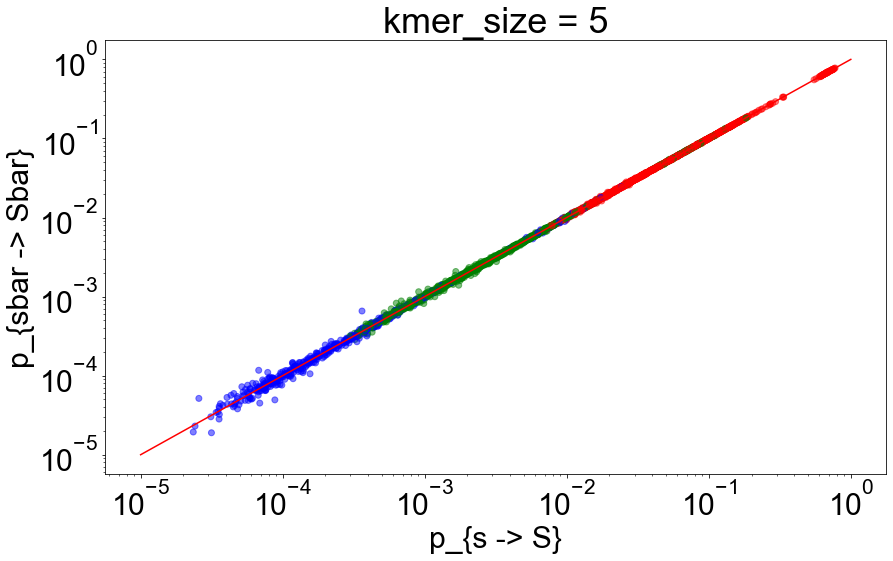

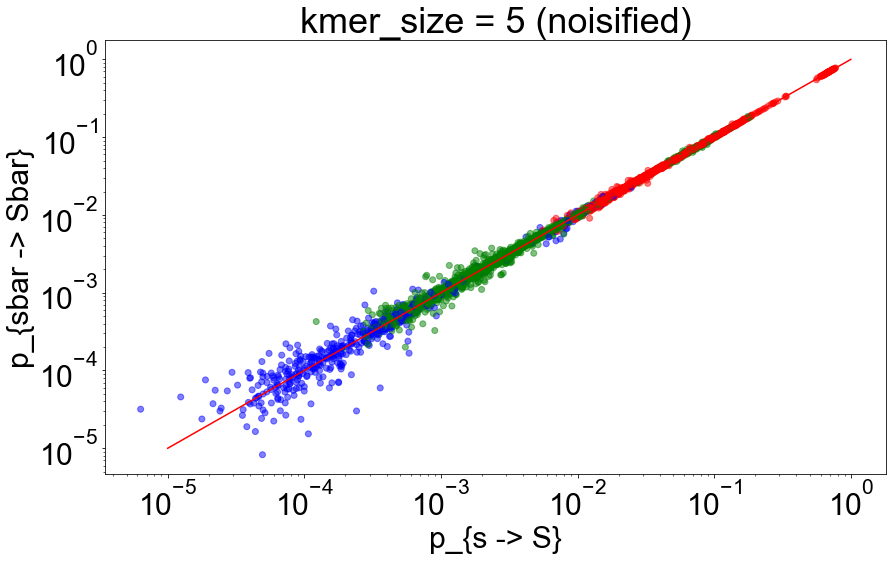

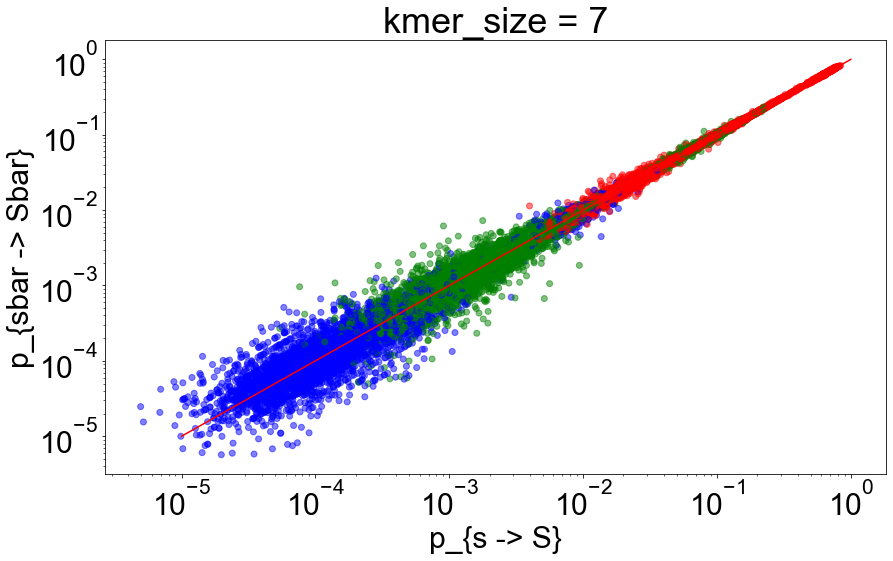

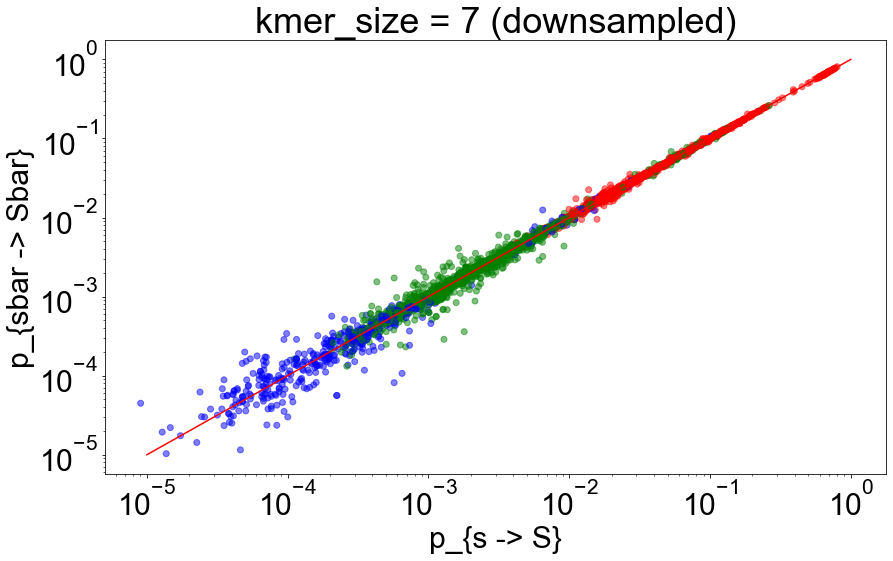

In [2]:
import random

from kmer import ( 
    compute_kmers, 
    get_reverse_complement,
    get_complement
)

def get_kmer_size(kmer_dict): 
    for kmer in kmer_dict.keys(): 
        return len(kmer)

def get_counts(kmer_counts, kmer, ALT_state): 
    data = kmer_counts[kmer]
    return data['ALTStateCounts'][ALT_state], data['count'] 

def estimate_ALT_state_probability(kmer_counts, kmer, ALT_state): 
    # see define-model/germline-model.ipynb: 
    s_to_S_count, s_count = get_counts(kmer_counts, kmer, ALT_state)
    num = s_to_S_count 
    den = s_count 
    # estimate probabilities for multinomial distribution: https://math.stackexchange.com/a/421838
    return num/den if den > 0 else None

def estimate_kmer_probabilities_by_strand(kmer_counts):
    xs, ys, labels, ALT_multiplicities = [], [], [], []
    kmers_visited = set()
    for kmer in compute_kmers(get_kmer_size(kmer_counts)): 
        if kmer in kmers_visited: continue

        kmer_bar = get_reverse_complement(kmer)
        kmers_visited.update({kmer, kmer_bar})

        for ALT_state in compute_possible_ALT_states(kmer):
            ALT_state_bar = get_complement(ALT_state)

            probability = estimate_ALT_state_probability(kmer_counts, kmer, ALT_state)
            xs.append(probability)

            probability_bar = estimate_ALT_state_probability(kmer_counts, kmer_bar, ALT_state_bar)
            ys.append(probability_bar)

            label = (kmer, ALT_state, kmer_bar, ALT_state_bar)
            labels.append(label)

            ALT_multiplicities.append(len(ALT_state.strip('{}').split(',')))
    
    return xs, ys, labels, ALT_multiplicities

def integer_to_color(integer): 
    if integer == 1: return 'red'
    if integer == 2: return 'green'
    if integer == 3: return 'blue'
    
def plot_substitution_probabilities_using_kmer_and_kmerbar(model_filename, model_label, sample_size=None):
    model = read_model(model_filename)
    kmer_counts = model['kmerCounts']
    xs, ys, labels, ALT_multiplicities = estimate_kmer_probabilities_by_strand(kmer_counts)
    number_data_points = len(xs)
    
    if sample_size:      
        xs, ys, labels, ALT_multiplicities = \
            list(zip(*random.choices(list(zip(xs, ys, labels, ALT_multiplicities)), k=sample_size)))
    
    font = {
        'family': 'Arial',
        'weight': 'normal',
        'size': 30
    }
    colors = [integer_to_color(ALT_multiplicity) for ALT_multiplicity in ALT_multiplicities]

    import matplotlib
    matplotlib.rc('font', **font)  
    fig = plt.figure()
    fig.set_size_inches(14, 8)
    plt.scatter(xs, ys, color=colors, alpha=0.5)
    plt.plot([1e-5, 1e0], [1e-5, 1e0], 'red')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(model_label)

    # See the model specification to interpret the x and y axis labels: 
    # https://github.com/quinlan-lab/constraint-tools/blob/main/define-model/germline-model.ipynb
    plt.xlabel('p_{s -> S}')
    plt.ylabel('p_{sbar -> Sbar}')
    
    return number_data_points

def plot_substitution_probabilities_using_kmer_and_kmerbar_ALL_MODELS(kmer_size):  
    assert kmer_size in [3, 5]
    
    number_data_points = plot_substitution_probabilities_using_kmer_and_kmerbar(
        model_filename = f'{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-{kmer_size}.trainSet-{TRAIN_SET_LABEL}.json',
        model_label = f'kmer_size = {kmer_size}'
    )

    plot_substitution_probabilities_using_kmer_and_kmerbar(
        model_filename = f'{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-{kmer_size}.trainSet-{TRAIN_SET_LABEL}.noisified.json',
        model_label = f'kmer_size = {kmer_size} (noisified)'
    )

    plot_substitution_probabilities_using_kmer_and_kmerbar(
        model_filename = f'{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-7.trainSet-{TRAIN_SET_LABEL}.json',
        model_label = 'kmer_size = 7'
    )

    plot_substitution_probabilities_using_kmer_and_kmerbar(
        model_filename = f'{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-7.trainSet-{TRAIN_SET_LABEL}.json',
        model_label = 'kmer_size = 7 (downsampled)',
        sample_size = number_data_points
    )
    
plot_substitution_probabilities_using_kmer_and_kmerbar_ALL_MODELS(kmer_size=5)